# Plotting thrombolysis rate by feature value for low and high thrombolysing hopsitals

## Plain English summary

This experiment plots the relationships between feature values and thrombolysis use for low and high thrombolysing hospitals. The high and low thrombolysing hopsitals are taken as the top and bottom 30 hospitals as ranked by the predicted thrombolysis use in the same 10k cohort of patients. We also call the top 30 thrombolysing hospitals 'benchmark' hospitals.

We find that thrombolysis use in low thrombolysing hospitals follows the same general relationship with feature values as the high thrombolysing hospitals, but thrombolysis is consistently lower.

## Aims

* Plots the relationships between feature values and thrombolysis use for low and high thrombolysing hospitals

## Observations

* Thrombolysis use in low thrombolysing hospitals follows the same general relationship with feature values as the high thrombolysing hospitals, but thrombolysis is consistently lower.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [2]:
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data on predicted 10k cohort thrombolysis use at each hospital
Use the hospitals thrombolysis rate on the same set of 10k patients to select the 30 hospitals with the highest thrombolysis rates.

In [3]:
thrombolysis_by_hosp = pd.read_csv(
    './output/04_xgb_10_features_10k_thrombolysis_rate_by_hosp.csv', index_col='stroke_team')
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

In [4]:
thrombolysis_by_hosp.head()

,Thrombolysis rate
stroke_team,
VKKDD9172T,0.4527
GKONI0110I,0.4132
HPWIF9956L,0.4131
CNBGF2713O,0.4093
TPXYE0168D,0.3962


## Load 10K test data

In [5]:
data_loc = '../data/10k_training_test/'
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

In [6]:
test.head()

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,...,AFAnticoagulentHeparin_missing,S2NewAFDiagnosis_No,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis
0,VUHVS8909F,72.5,80.0,0,3,2.0,2.0,2.0,3.0,3.0,...,0,1,0,0,0,0,0,0,1,0
1,HZNVT9936G,72.5,87.0,2,0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,1,1,0,0,0,1,0
2,FAJKD7118X,67.5,140.0,3,0,2.0,0.0,1.0,2.0,2.0,...,0,1,0,0,1,0,0,0,1,1
3,TPXYE0168D,77.5,108.0,0,0,0.0,0.0,0.0,1.0,2.0,...,1,0,0,1,1,0,0,0,1,1
4,DNOYM6465G,87.5,51.0,4,1,1.0,1.0,0.0,1.0,1.0,...,0,0,0,1,1,0,0,0,1,0


## Get data for benchmark hospitals and low thrombolysing hopsitals

In [7]:
# Get list of key features to plot
number_of_features_to_use = 8
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')

# Get benchmark data
benchmark_hospitals = list(thrombolysis_by_hosp.index)[0:30]
mask = test.apply(lambda x: x['StrokeTeam'] in benchmark_hospitals, axis=1)
benchmark_data = test[mask]
benchmark_data = benchmark_data[key_features]
benchmark_data.rename(columns=feature_name_dict, inplace=True)
benchmark_data.sort_values('Stroke team', inplace=True, axis=0)

# Get low thrombolysis hospital data
low_thrombolysis_hospitals = list(thrombolysis_by_hosp.index)[-30:]
mask = test.apply(lambda x: x['StrokeTeam'] in low_thrombolysis_hospitals, axis=1)
low_thrombolysis_data = test[mask]
low_thrombolysis_data = low_thrombolysis_data[key_features]
low_thrombolysis_data.rename(columns=feature_name_dict, inplace=True)
low_thrombolysis_data.sort_values('Stroke team', inplace=True, axis=0)

## Plot thrombolysis by feature value

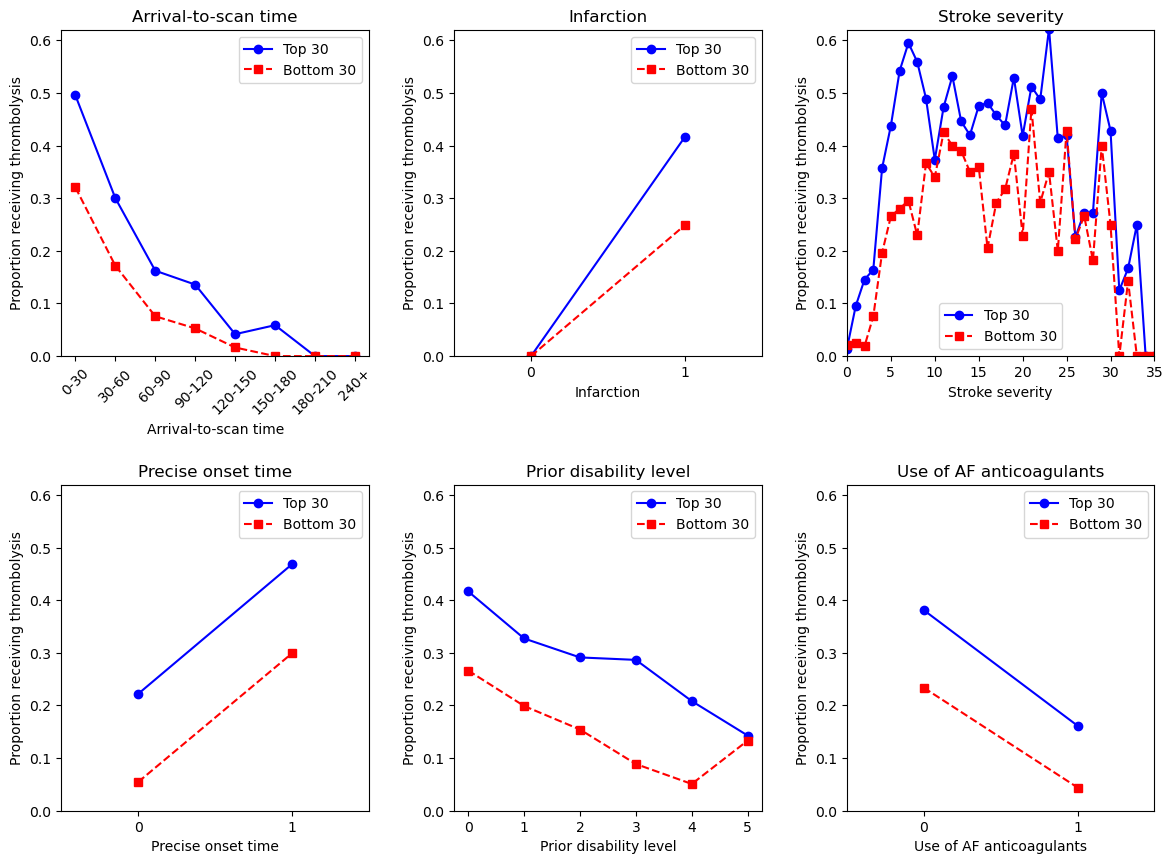

In [8]:
feat_to_show = [feature_name_dict[feat] for feat in key_features][0:7]
feat_to_show.remove('Stroke team')
fig = plt.figure(figsize=(12,9))

for n, feat in enumerate(feat_to_show):
    
    ax = fig.add_subplot(2,3,n+1)
    
    ### Plot benchmark units ###
    
    feature_data = benchmark_data[feat]
    
    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data
       
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = 8
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list =  [f'{i*step}-{(i+1)*step}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 45
        
        # create list of unique categories in the feature data
        category_list = np.unique(feature_data)
        
        # if numerical set as int, otherwise set as a range
        try:
            category_list = [int(i) for i in category_list]
        except: 
            category_list = range(len(category_list))
            
    feature_data = pd.DataFrame(feature_data)
    feature_data['Thrombolysis'] = benchmark_data['Thrombolysis']
    
    df = feature_data.groupby(feat).mean()

    ax.plot(df, color='b', marker='o', linestyle='solid', label='Top 30')
    
    ### Plot low thrombolysing units ###
    
    feature_data = low_thrombolysis_data[feat]
    
    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data
       
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = 8
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list =  [f'{i*step}-{(i+1)*step}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 45
        
        # create list of unique categories in the feature data
        category_list = np.unique(feature_data)
        
        # if numerical set as int, otherwise set as a range
        try:
            category_list = [int(i) for i in category_list]
        except: 
            category_list = range(len(category_list))
            
    feature_data = pd.DataFrame(feature_data)
    feature_data['Thrombolysis'] = low_thrombolysis_data['Thrombolysis']
    
    df = feature_data.groupby(feat).mean()

    ax.plot(df, color='r', marker='s', linestyle='dashed', 
            label='Bottom 30')
    ax.set_title(feat)
    ax.set_ylim(0, 0.62)
    ax.set_xlabel(feat) 
    ax.set_ylabel('Proportion receiving thrombolysis')
    ax.legend()
    
    # Customise axis for particular plots
    # Force just two points on axis when a binary feature
    if len(df.index)  == 2:
        ax.set_xticks(df.index)
        ax.set_xlim(-0.5, 1.5)
    # Censor stroke severity at 35 due to lack of data
    if feat == 'Stroke severity':
        ax.set_xlim(0,35)
       
    # Rotate ticks for arrival-to-scan
    if feat == 'Arrival-to-scan time':
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

plt.tight_layout(pad=2)
plt.savefig('output/09_compare_thrombolysis_by_feature.jpg', dpi=300,
     bbox_inches='tight', pad_inches=0.2)